In [11]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Read the root directory of images and extract pixel features and flatten into a 1d vector

In [2]:
dataset_path = 'Lab 2 Data' 
features = []
labels = []

# Loop over each subject folder
for subject_folder in sorted(os.listdir(dataset_path)):
    if subject_folder.startswith('s'):
        subject_number = int(subject_folder[1:])  
        subject_path = os.path.join(dataset_path, subject_folder)

        # Loop over each image in the subject folder
        for image_file in sorted(os.listdir(subject_path)):
            if image_file.endswith('.pgm'):
                image_path = os.path.join(subject_path, image_file)
                
                # Load the image
                img = Image.open(image_path)
                img_array = np.array(img)
                
                # Flatten the image to 1D vector
                flattened_vector = img_array.flatten()

                # Append data and label
                features.append(flattened_vector)
                labels.append(subject_number)

features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)      

Features shape: (400, 10304)
Labels shape: (400,)


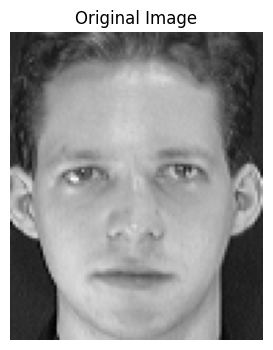

In [3]:
img  = features[0]

original = features[0].reshape(112,92)  # Assuming ORL face dataset shape

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.show()

### Split Data into Odd indexed rows for training and even indexed for testing

In [4]:
X_train = features[::2]
X_test  = features[1::2] 
y_train = labels[::2]
y_test  = labels[1::2]

In [5]:
import numpy as np

class PCA:
    def __init__(self, alpha=0.95):
        self.alpha = alpha
        self.cov_matrix = None
        self.eigen_vals = None
        self.eigen_vecs = None
        self.k = None
        self.top_k_vecs = None
        self.mu = None

    def _calculate_covariance(self, X):
        # Compute mean and center data
        self.mu = np.mean(X, axis=0)
        X_centered = X - self.mu
        # Use unbiased estimator: divide by n-1
        cov = (1.0 / (X_centered.shape[0] - 1)) * (X_centered.T @ X_centered)
        return cov

    def fit(self, X):
        # Fit PCA: compute covariance, eigen decomposition, sort, and save
        self.cov_matrix = self._calculate_covariance(X)
        self.eigen_vals, self.eigen_vecs = np.linalg.eigh(self.cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigen_vals)[::-1]
        self.eigen_vals = self.eigen_vals[idx]
        self.eigen_vecs = self.eigen_vecs[:, idx]

        # Save for later use
        np.save('eigen_vals.npy', self.eigen_vals)
        np.save('eigen_vecs.npy', self.eigen_vecs)
        np.save('mean_vector.npy', self.mu)
        
        self.set_alpha(self.alpha)

    def load_eigen(self):
        # Load precomputed eigenvalues, eigenvectors, and mean
        self.eigen_vals = np.load('eigen_vals.npy')
        self.eigen_vecs = np.load('eigen_vecs.npy')
        self.mu = np.load('mean_vector.npy')

    def set_alpha(self, alpha):
        # Set variance threshold and compute top-k components
        self.alpha = alpha
        cum_var = np.cumsum(self.eigen_vals)
        total = cum_var[-1]
        ratio = cum_var / total
        self.k = np.searchsorted(ratio, self.alpha) + 1
        self.top_k_vecs = self.eigen_vecs[:, :self.k]

    def transform(self, X):
        X_centered = X - self.mu
        return X_centered @ self.top_k_vecs

    def fit_transform(self, X):
        self.fit(X)
        self.set_alpha(self.alpha)
        return self.transform(X)

    def inverse_transform(self, Z):
        self.set_alpha(self.alpha)
        return (Z @ self.top_k_vecs.T) + self.mu


Alpha: 0.8
Number of principal components retained: 44
Reduced feature shape: (400, 44)


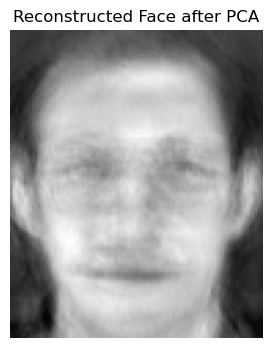

Alpha: 0.85
Number of principal components retained: 68
Reduced feature shape: (400, 68)


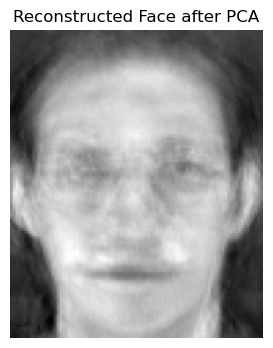

Alpha: 0.9
Number of principal components retained: 111
Reduced feature shape: (400, 111)


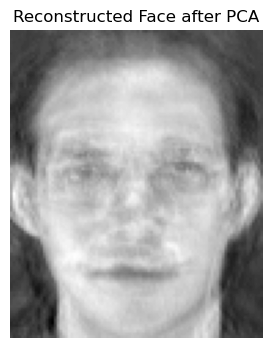

Alpha: 0.95
Number of principal components retained: 190
Reduced feature shape: (400, 190)


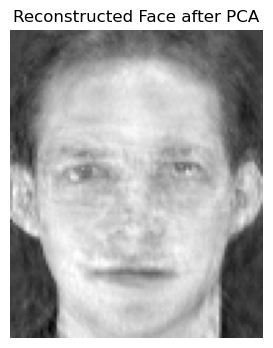

In [ ]:
pca = PCA()

pca.load_eigen()

alphas = [0.8, 0.85, 0.9, 0.95]

for alpha in alphas:
    pca.set_alpha(alpha)
    reduced_features = pca.transform(features)
    
    print(f"Alpha: {alpha}")
    print(f"Number of principal components retained: {pca.k}")
    print(f"Reduced feature shape: {reduced_features.shape}")

    samples = reduced_features[0:1]

    for sample in samples:
        plt.figure(figsize=(8, 4))
        
        reconstructed_sample = pca.inverse_transform(sample)
        
        reconstructed_sample = reconstructed_sample.reshape(112, 92)

        plt.imshow(reconstructed_sample, cmap='gray')
        plt.title("Reconstructed Face after PCA")
        plt.axis('off')
        plt.show()
        


## Bonus: Design an autoencouder NN

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [32]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(10304, 5152),
            nn.ReLU(),
            nn.Linear(5152, 2576),
            nn.ReLU(),
            nn.Linear(2576, 1288),
           
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
         
            nn.Linear(1288, 2576),
            nn.ReLU(),
            nn.Linear(2576, 5152),
            nn.ReLU(),
            nn.Linear(5152, 10304),
            nn.Sigmoid()        
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [34]:
def train(lr= 0.0005, epochs = 100,features = None):
    features = features.astype(np.float32) 
    features /= 255.0
    
    # Convert features to a Tensor
    features_tensor = torch.from_numpy(features)
    dataset = TensorDataset(features_tensor)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    model = AutoEncoder(input_size=10304)  # Make sure to pass input size if needed
    
    Loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            inputs = batch[0].to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = Loss(outputs, inputs)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    return model    

In [ ]:
model = train(epochs = 200,features= features)

Epoch [1/50], Loss: 0.041437
Epoch [2/50], Loss: 0.038112
Epoch [3/50], Loss: 0.029571
Epoch [4/50], Loss: 0.025772
Epoch [5/50], Loss: 0.025055
Epoch [6/50], Loss: 0.024829
Epoch [7/50], Loss: 0.025431
Epoch [8/50], Loss: 0.023714
Epoch [9/50], Loss: 0.024535
Epoch [10/50], Loss: 0.024024
Epoch [11/50], Loss: 0.024275
Epoch [12/50], Loss: 0.024461
Epoch [13/50], Loss: 0.024796
Epoch [14/50], Loss: 0.024784
Epoch [15/50], Loss: 0.023693
Epoch [16/50], Loss: 0.024085
Epoch [17/50], Loss: 0.023839
Epoch [18/50], Loss: 0.023049
Epoch [19/50], Loss: 0.022122
Epoch [20/50], Loss: 0.023375
Epoch [21/50], Loss: 0.022618
Epoch [22/50], Loss: 0.023248
Epoch [23/50], Loss: 0.022831
Epoch [24/50], Loss: 0.022802
Epoch [25/50], Loss: 0.022698
Epoch [26/50], Loss: 0.022372
Epoch [27/50], Loss: 0.022693
Epoch [28/50], Loss: 0.022708
Epoch [29/50], Loss: 0.023546
Epoch [30/50], Loss: 0.023021
Epoch [31/50], Loss: 0.022482
Epoch [32/50], Loss: 0.022877
Epoch [33/50], Loss: 0.022387
Epoch [34/50], Loss

In [28]:
# store pickle file
import pickle
with open('autoencoder_model.pkl', 'wb') as f:
    pickle.dump(model, f)

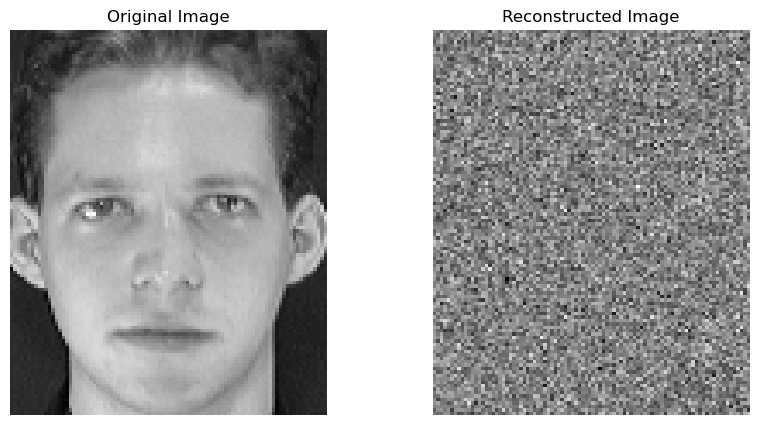

In [ ]:

model = AutoEncoder(input_size=10304).to(device)

sample_idx = 0
sample_image = features[sample_idx]  # shape (10304,)
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)

model.eval()
with torch.no_grad():
    input_tensor = sample_image_tensor.unsqueeze(0)  
    
    reconstructed_tensor = model(input_tensor)  
    
    reconstructed_image = reconstructed_tensor.squeeze(0).cpu().numpy()

original_image = sample_image.reshape(112, 92)
reconstructed_image = reconstructed_image.reshape(112, 92)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()



In [ ]:
class GMM:
    def __init__(self, K, data_matrix):
        self.K = K
        self.data_matrix = data_matrix
        self.no_of_samples = len(data_matrix)
        self.no_of_feats = len(data_matrix[0])
        print("Data matrix shape:", self.data_matrix.shape)
        print("Number of samples:", self.no_of_samples)
        print("Number of features:", self.no_of_feats)
        print("Number of clusters:", self.K)
        # Initialize mixing coefficients uniformly
        self.pi = np.ones(self.K) / self.K

        # Initialize responsibility vector
        self.responsibility_vectors = np.zeros((self.no_of_samples, self.K))
        print("Responsibility vectors shape:", self.responsibility_vectors.shape)
        print("Responsibility vectors:", self.responsibility_vectors)

        # Initialize means
        random_indices = np.random.choice(self.no_of_samples, self.K, replace=False)
        print("Random indices:", random_indices)
        # make float to avoid overflow in multivariate normal
        self.means = self.data_matrix[random_indices]
        self.means = self.means.astype(np.float32)
        print("Means shape:", self.means.shape)
        print("Means:", self.means)

        # Initialize covariances
        self.covariances = np.zeros((self.no_of_feats, self.no_of_feats, self.K))
        for k in range(self.K):
            self.covariances[:,:,k] = np.eye(self.no_of_feats)

    def fit(self):
        for i in range(5):
            for sample in range(self.no_of_samples):
                sum = 0
                for k in range(self.K):
                    print("Sample:", self.data_matrix[sample])
                    print("Mean:", self.means[k])
                    print("Covariance:", self.covariances[:,:,k])
                    sum += self.pi[k] * multivariate_normal.pdf(
                        self.data_matrix[sample], mean=self.means[k], cov=self.covariances[:,:,k])
                
                for k in range(self.K):
                    self.responsibility_vectors[sample][k] = (self.pi[k] * multivariate_normal.pdf(
                        self.data_matrix[sample], mean=self.means[k], cov=self.covariances[:,:,k])) / sum
            
            # update mixing coefficients
            for sample in range(self.no_of_samples):
                for k in range(self.K):
                    self.pi[k] = np.sum(self.responsibility_vectors[:, k]) / self.no_of_samples
                    print("Mixing coefficients:", self.pi)

            # update means
            for k in range(self.K):
                numerator = 0
                denominator = 0
                for sample in range(self.no_of_samples):
                    numerator += self.responsibility_vectors[sample][k] * self.data_matrix[sample]
                    denominator += self.responsibility_vectors[sample][k]
                self.means[k] = numerator / denominator

            # update covariances
            for k in range(self.K):
                numerator = 0
                denominator = 0
                for sample in range(self.no_of_samples):
                    diff = self.data_matrix[sample] - self.means[k]
                    numerator += self.responsibility_vectors[sample][k] * (diff ** 2)
                    denominator += self.responsibility_vectors[sample][k]
                self.covariances[k] = numerator / denominator
                        



In [58]:
class GMM2:
    def __init__(self, K, data_matrix):
        self.K = K
        self.data_matrix = data_matrix
        self.no_of_samples = len(data_matrix)
        self.no_of_feats = len(data_matrix[0])
        print("Data matrix shape:", self.data_matrix.shape)
        print("Number of samples:", self.no_of_samples)
        print("Number of features:", self.no_of_feats)
        print("Number of clusters:", self.K)
        
        # Initialize mixing coefficients uniformly
        self.pi = np.ones(self.K) / self.K
        print("Mixing coefficients shape:", self.pi.shape)
        print("Mixing coefficients:", self.pi)

        # Initialize responsibility matrix
        self.responsibility_vectors = np.zeros((self.no_of_samples, self.K))
        print("Responsibility vectors shape:", self.responsibility_vectors.shape)
        print("Responsibility vectors:", self.responsibility_vectors)
        
        # Initialize means by randomly selecting K data points
        random_indices = np.random.choice(self.no_of_samples, self.K, replace=False)
        self.means = self.data_matrix[random_indices].astype(np.float64)
        print("Means shape:", self.means.shape)
        print("Means:", self.means)
        
        # Initialize covariances as identity matrices
        self.covariances = np.array([np.eye(self.no_of_feats) for _ in range(self.K)])
        print("Covariances shape:", self.covariances.shape)
        print("Covariances:", self.covariances)

    def fit(self, max_iter=100, tol=1e-8):
        prev_log_likelihood = -np.inf
        
        for iteration in range(max_iter):
            # E-step: Compute responsibilities
            for k in range(self.K):
                try:
                    self.responsibility_vectors[:, k] = self.pi[k] * multivariate_normal.pdf(
                        self.data_matrix, mean=self.means[k], cov=self.covariances[k], allow_singular=True)
                except:
                    # Handle numerical instability
                    self.responsibility_vectors[:, k] = 1e-10

            print("Responsibility vectors after E-step:", self.responsibility_vectors)       
            # Normalize responsibilities
            sum_resp = self.responsibility_vectors.sum(axis=1, keepdims=True)
            sum_resp[sum_resp == 0] = 1e-10  # Avoid division by zero
            self.responsibility_vectors /= sum_resp
            
            # Compute log likelihood for convergence check
            current_log_likelihood = np.log(sum_resp).sum()
            
            # M-step: Update parameters
            # Update mixing coefficients
            Nk = self.responsibility_vectors.sum(axis=0)
            self.pi = Nk / self.no_of_samples
            
            # Update means
            for k in range(self.K):
                self.means[k] = np.sum(self.responsibility_vectors[:, k:k+1] * self.data_matrix, axis=0) / Nk[k]
            
            # Update covariances
            for k in range(self.K):
                diff = self.data_matrix - self.means[k]
                weighted_diff = self.responsibility_vectors[:, k:k+1] * diff
                self.covariances[k] = (weighted_diff.T @ diff) / Nk[k]
                # Add small value to diagonal for numerical stability
                self.covariances[k] += 1e-6 * np.eye(self.no_of_feats)
            
            # Check for convergence
            if np.abs(current_log_likelihood - prev_log_likelihood) < tol:
                print(f"Converged at iteration {iteration}")
                break
                
            prev_log_likelihood = current_log_likelihood
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, log likelihood: {current_log_likelihood}")

    def predict(self, X):
        responsibilities = np.zeros((len(X), self.K))
        for k in range(self.K):
            responsibilities[:, k] = self.pi[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k], allow_singular=True)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities.argmax(axis=1)

In [59]:
mat = np.array([[123, 45, 255, 67],
[89, 12, 200, 34],
[56, 78, 90, 150],
[210, 0, 100, 180],
[32, 255, 1, 60]])
GMM_model = GMM2(K=2, data_matrix=mat)
GMM_model.fit()

Data matrix shape: (5, 4)
Number of samples: 5
Number of features: 4
Number of clusters: 2
Mixing coefficients shape: (2,)
Mixing coefficients: [0.5 0.5]
Responsibility vectors shape: (5, 2)
Responsibility vectors: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Means shape: (2, 4)
Means: [[210.   0. 100. 180.]
 [ 32. 255.   1.  60.]]
Covariances shape: (2, 4, 4)
Covariances: [[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]
Responsibility vectors after E-step: [[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.01266515 0.        ]
 [0.         0.01266515]]
Iteration 0, log likelihood: -77.81535541657865
Responsibility vectors after E-step: [[0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [5.06605918e+09 0.00000000e+00]
 [0.00000000e+00 5.06605918e+09]]
Responsibility vectors after E-step: [[0.00000000e+00 0.00000000e+00]
 [0.000